<div style="color:Navy"> 

<div style="text-align:center"> 

***
# <u>TP4:</u>
# Filtrage et Convolutions
    
<p style="text-align: center; color:gray"><i>@Author:</i> Marc-Aurèle Rivière</p>

***
        
</div>
    
<u>**Plan:**</u>

1. [**Filtrage & Convolutions : notions**](#1):
    1. Filtrage spatial: convolutions
    2. Filtrage en fréquence
    

2. [**Lissage & Filtres passe-bas**](#2): Moyen, Gaussien, Median

    
3. [**Accentuation & Filtres passe-haut**](#3): Sobel, Prewitt, Laplace, Canny
    
</div>

In [4]:
'''''''''''''''''''''''''''''''''
#################################
#  Code global pour tout le TP  #
#################################
'''''''''''''''''''''''''''''''''

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running on Colaboratory")
    from google.colab import drive, files

    drive.mount('/content/gdrive', force_remount=True)
    root_path = 'gdrive/My Drive/3. Doctorat/Enseignements/[Intro] Image Processing/TP4/'  # A modifier à votre chemin d'accès
    img_path = root_path + "img/"
else:
    print("Not running on Colaboratory")
    root_path = "/"
    img_path = "img/"

Not running on Colaboratory


# <span style="color: Green;text-decoration: underline" id="1">I. Filtrage & Convolution : notions</span>
***

Le principe du **filtrage** est de modifier la valeur d'un signal (ici les pixels d'une image) sur la base des valeurs des ses voisins. C'est donc une **opération locale**, qui va se baser soit sur les voisins du pixel dans le temps (pour les séries/signaux temporels), ou dans l'espace (pour les données structurées, comme les images).

Cette opération peut avoir différents objectifs: changer l'aspect du signal (i.e. améliorer ou débruiter une image) ou en extraire des caractéristiques intéressantes (coins, bordures, ...).

N'entrent dans cette catégorie que les transformations se basant sur les valeurs des pixels de l'image. D'autres transformations comme les changements d'échelles, projections, translations, rotations, ... ne sont pas considérées comme des opérations de filtrage.


> Une opération de filtrage est au **domaine fréquentiel** ce que la convolution est au **domaine spatial** (e.g. images).

## <span style="color: DodgerBlue;text-decoration: underline">I.1 Filtrage spatial : convolutions</span>

### I.1.a Principes généraux:

La **convolution** est une opération mathématique de deux fonctions $f$ et $g$ qui produit une troisième fonction représentant comment la forme de la première est modifiée par la seconde.

Mathématiquement, le **produit de convolution** entre une fonction $f$ et $g$ est dénotée : 

$$
\Large{f * g = y}
$$

Appliquée à un signal continu 1D, elle peut être formélisée comme :

$$
\Large (f*g)(t)\,=\, f(t) * g(t) \,=\, \int _{-\infty }^{\infty }f(t-\tau )g(\tau )\,d\tau
$$

Pour un filtre de taille finie $n$, appliqué à un signal discret 1D, elle peut être représentée comme:

$$
\Large (f*g)(t)\,=\, f(t) * g(t) \,=\, \sum _{\tau \ = \ 1}^{n}f(t-\tau )g(\tau )
$$

Avec $n$ la taille du filtre impulsionel .

<br>

<u>Illustration</u>: cas d'une convolution 1D

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif" width="150%">

***

Dans le cas des images (signaux 2D ou 3D), la **convolution** transforme une image en modifiant la valeur de chaque pixel par une **somme pondérée des valeurs des pixels avoisinants.** Il s'agit d'une **transformation linéaire locale** vu que la nouvelle valeur d'un pixel peut être exprimée comme une somme pondérée (des valeurs de ses voisins sur l'image non-modifiée).

Elle peut être formalisée comme:

$$
\Large I'(x, y) = I(x,y) * K(x,y) = \sum_{k_1\ =\ 1}^{n} \sum_{k_2\ =\ 1}^{n} I(x - k_1, y - k_2)K(k_1, k_2)
$$

Avec :
* $K$ le *kernel*, une matrice carrée impaire de dimension $n*n$
* $I'$ l'image convoluée résultant du produit de convolution de $I$ et de $K$

Ce sont les **coefficients** de cette pondération effectuée entre les deux fonctions (dans notre cas, l'image et la fonction de convolution) qui influencent l'effet de la convolution sur l'image d'origine (lissage, extraction de bordures, ...). Ces coefficients sont représentée par une matrice (carrée, impaire) que l'on appelle communément le **noyau** (*kernel*) de la convolution. 

Certains *kernels* possèdent une dénomination spécifique, généralement découlant d'un opérateur connu (dont ils sont une approximation discrète - e.g. filtre Gaussien ou Laplacien), ou de leur inventeur (e.g. filtre de Sobel).

<img src="https://benchpartner.com/wp-content/uploads/2019/06/sobel-filter-edge-detctor.png">

<u>Remarque</u>: les convolutions peuvent être vues comme une extension des opérations morphologiques :
* Dans les OM, le noyau était binaire (ou éventuellement trinaire), et la nouvelle valeur du pixel devient 0 ou 1 en fonction de la correspondance (*hit, fit, miss*) entre l'image et le noyau.
* Dans les convolutions, le noyau prends des valeurs entières $[0, 255]$, et la nouvelle du pixel sera également entre $[0, 255]$, calculée par un produit de convolution entre le noyau et l'image.


***

L'objectif d'une convolution est de **transformer l'image afin de faire ressortir / extraire des informations utiles**. Etant une opération locale, la convolution suppose que l'information utile à la transformation d'un pixel donné est entièrement (ou du moins, majoritairement) contenue que dans les $3*3 = 9$ ou $5*5 = 25$ (etc, selon le choix de taille du noyau) voisins immédiats (pour une image 2D). La dimension du noyau, donc la distance de "visibilité" de la convolution à un moment donné, est également appelé son champ récepteur (*receptive field*).

Cela suppose également que la valeur (et l'information contenue) d'un pixel est liée à celle de ses voisins immédiats, ce qui est le cas quand cette image contient des objets (et donc du signal), et pas uniquement du bruit (aléa). Par exemple, il est naturel de supposer que si un pixel $i$ appartient à un objet, ses voisins immédiats ont plus de chance d'y appartenir également (comparé à un pixel plus éloigné). Leurs valeurs de luminance ou de chrominance ont donc de grandes chances d'être corrélées. On peut émmettre l'hypothèse que cette dépendance des pixels avoisinants est présente dans toutes les directions (e.g. *8-connectivity*) si l'on se trouve à l'intérieur de l'objet, ou seulement dans certaines directions (e.g. *horizontal / vertical 2-connectivity*) si l'on se trouve sur une bordure, ...

<img src="https://images.deepai.org/converted-papers/1906.03366/images/Connectedness.jpg" width=300>

***

Une convolution est une opération en **fenêtre glissante** (*sliding window*): l'on applique le noyau de manière successive à chaque pixel de l'image, du coin haut-gauche `(0,0)` au coin bas-droit `(img.shape[0], img.shape[1])`.

<img src="https://mlnotebook.github.io/img/CNN/convSobel.gif">   

<u>Légende</u>: La matrice centrale représente le noyau de convolution, et la matrice bleue represent l'image de sortie, également appelée *Feature Map* (surtout dans le domaine du *Deep Learning*).

<br>

<u>Exemple de convolution avec le filtre de Sobel horizontal</u>:

![Exemple d'une convolution avec le filtre de Sobel](https://miro.medium.com/max/1893/1*wju0Urp6KpAT11wktTp5Sg.png "Exemple d'une convolution avec le filtre de Sobel")

<u>Remarque</u>: Pour une illustration interactive, visiter cette page: http://setosa.io/ev/image-kernels/

***

### I.1.b *Strides & Padding* :

#### Strides:

Pas de progression du kernel dans chaque direction (x et y). Par défaut, il avance de 1 en 1 pour parcourir l'ensemble des pixels.

<img src="https://miro.medium.com/max/790/1*L4T6IXRalWoseBncjRr4wQ@2x.gif" alt="Exemple de convolution avec Stride = 1"  title="Exemple de convolution avec Stride = 1" width="40%">

<img src="https://miro.medium.com/max/721/1*4wZt9G7W7CchZO-5rVxl5g@2x.gif" alt="Exemple de convolution avec Stride = 2"  title="Exemple de convolution avec Stride = 2" width="40%">

Augmenter le pas permet d'avoir moins de superposition / redondance entre les champs récepteurs, et va diminuer la taille de l'image résultante.

***
#### Padding:

Ajout de marges (lignes et colonnes de pixels vides - à 0 - autour de l'image) afin d'éviter les effets de bords (qui nous feront perdre un certain nombre de lignes et de colonnes sur chaque bord de l'image). Le *padding* permet donc d'obtenir un résultat de la même dimension que l'image d'entrée.

<img src="https://miro.medium.com/max/1063/1*W2D564Gkad9lj3_6t9I2PA@2x.gif" alt="Exemple de convolution avec Padding = Same"  title="Exemple de convolution avec Padding = Same" width="40%">

<u>Remarque</u>: le paramètre de padding d'une convolution prends généralemens l'une des 2 valeurs suivantes:
* `Valid`: pas de padding appliqué $\rightarrow$ donc perte d'informations aux bordures, et la taille de l'image résultante sera inférieure à celle d'origine.
* `Same`: ajout de marges dont la taille est calculée automatiquement de sorte à ce que les dimensions des images d'entrée et de sortie soient identiques.

### I.1.c Types de convolutions:

Au delà du type de kernel employé, il existe différents types de convolutions qui dépendent de comment le noyau est appliqué à l'image :
* Convolutions 2D (`conv2D`), mono ou multi-canaux.
* Convolutions 3D (`conv3D`)
* Transposed convolutions (aka Deconvolution)
* Atrous convolutions (aka Dilated convolutions)
* Depthwise separable convolutions
* Flattened convolutions
* Grouped convolutions
* ...

#### Convolutions 2D:

Jusque-là, les exemples que nous avons vus étaient des convolutions 2D mono-canal : elles s'appliquaient à une image 2D avec un seul canal (niveaux de gris). Une convolution peut également être multi-canaux, par exemple si elle s'applique à chaque canal d'une image couleur. Un kernel multi-canaux peut-être calculé de deux manières différentes :
1. Convolution séparée (de taille `n*n*1`) sur chaque canal, et fusion des 3 images resultantes à postériori.
2. Convolution combinée des 3 cannaux (filtre 3D de taille `n*n*3`) donnant une image en sortie.

<u>Illustration du cas 1</u>:

![Convolution d'une image couleur en filtrant chaque canal de manière séparée](https://miro.medium.com/max/1166/1*8dx6nxpUh2JqvYWPadTwMQ.gif "Convolution d'une image couleur en filtrant chaque canal de manière séparée")

![Fusion des résultats de la convolution de chacun des canaux pour obtenir le résultat final](https://miro.medium.com/max/1088/1*CYB2dyR3EhFs1xNLK8ewiA.gif "Fusion des résultats de la convolution de chacun des canaux pour obtenir le résultat final")

<u>Illustration du cas 2</u>:

![Exemple de convolution 3D](https://cdn-images-1.medium.com/max/1000/1*tmKo_Dvlf3bHCMFx_PKZYA.gif "Exemple de convolution 3D")

Utiliser un kernel 3D ne donne pas le même résultat de combiner le résultat de 3 convolutions 2D appliquées séparément aux 3 canaux: une convolution 3D va capter les interactions entre les valeurs / pixels des 3 canaux (en appliquant des sommes pondérées entre les mêmes pixels des différents canaux), alors que combiner les conv2D des 3 canaux suppose qu'ils sont indépendants.


<u>Remarque</u>: plusieurs kernels différents peuvent être appliquée à une même image d'entrée pour en extraire différentes caractéristiques (*features*) :

<img src="https://miro.medium.com/max/1124/1*45GSvnTvpHV0oiRr78dBiw@2x.png" width="40%">
<img src="https://miro.medium.com/max/1022/1*hbp1VRfeWnaREPrRLnxtqQ@2x.png" width="40%">

De même, l'ensemble des *feature maps* obtenues à la suite de l'application de ce groupe de filtres (*filter bank*) peuvent être passées dans une autre série de convolution, qui seront donc appliquées au résultats de la première série de convolution, pour en extraire des *features* de plus haut niveau en combinant celles obtenues précédemment. C'est un des principes fondateurs des réseaux de neurones à convolutions (*CNN*).

<img src="https://miro.medium.com/max/1740/1*uUYc126RU4mnTWwckEbctw@2x.png" width="50%">

***

#### Convolutions 3D:

Les convolutions 3D sont les convolutions enployant un filtre 3D qui va parcourir l'image d'entrée dans les 3 dimensions (à ne pas confondre avec le cas 2. des conv2D ou le filtre était 3D mais ne se déplaçait que selon les axes x et y).

*Similar as 2D convolutions which encode spatial relationships of objects in a 2D domain, 3D convolutions can describe the spatial relationships of objects in the 3D space. Such 3D relationship is important for some applications, such as in 3D segmentations / reconstructions of biomedical imagining, e.g. CT and MRI where objects such as blood vessels meander around in the 3D space.*

<img src="https://miro.medium.com/max/1610/1*wUVVgZnzBwYKgQyTBK_5sg.png" width="40%">

### I.1.d Fonctions utiles :

Pour les convolutions, nous allons utiliser :
* la fonction `convolve` et `convolve2D` de Scipy
* la fonction `filter2D` d'OpenCV 

```python
cv2.filter2D(src, ddepth, kernel, dst, anchor, delta, borderType)

scipy.signal.convolve2d(src, kernel, mode='full', boundary='fill', fillvalue=0)

scipy.ndimage.convolve(src, kernel, output=None, mode='reflect', cval=0.0, origin=0)
```
**Paramètres**
* `src`    : image de source
* `kernel` : masque (ou noyau) de convolution à coefficients réels
* `ddepth` : profondeur de l'image destination. Si valeur à -1: l'image destination aura la même profondeur que celle d'entrée.

Les autres paramètres servent (en majorité) à controller le comportement du filtre sur les rebords de l'image (padding, ...)

## <span style="color: DodgerBlue;text-decoration: underline">I.2 Filtrage fréquentiel</span>

### I.2.a Domaine fréquentiel :

Un signal (1D, comme un son) peut être représenté de deux manières:
* Dans le domaine temporel, ou est représentée l'évolution du signal dans le temps.
* Dans le domaine fréquentiel, ou sont représentées les différentes **composantes fréquentielles** qui forment ce signal quand combinées ensemble.

<img src="https://qph.fs.quoracdn.net/main-qimg-0cb386984a92c405f0aaeb2594761884">

<img src="https://thepracticaldev.s3.amazonaws.com/i/v1p6fhprekoheceqafw1.png">

Chacune de ces composantes fréquentielles est caractérisée par une amplitude, une fréquence, et une phase (son décalage dans le temps par rapport a un point d'origine commun). Décomposer un signal en une somme de composantes de différentes fréquences est permis par la **Transformée de Fourier** (TF) (cf. section suivante)

#### Fréquence et images:

La  fréquence,  dans  une  image,  représente  les  **variations  de  l’intensité  des  pixels** dans l'espace (2D) :
* Les **basses fréquences**, qui correspondent à des changements d’intensité  lents, correspondent aux régions homogènes et  floues de l'image.
* Les **hautes fréquences**, qui correspondent à des changements d’intensité rapides, correspondant souvent aux contours des objets.

Représenter une image dans le **domaine fréquentiel**, c'est représenter quelles composantes fréquentielles sont présentes dans l'image, et à quelle proportion (amplitude) elles contribuent à l'image globale.

### I.2.b Transformée de Fourier :

La **Transformée de Fourier** (ou TF) décompose un signal (continu ou discret) en une série (somme pondérée) de signaux périodiques.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/2b/Fourier_series_and_transform.gif" width="70%">

La Transformée de Fourier peut être formalisée comme :

$$
\Large s_{N}(x) = a_n \cos_n(x) + b_n \sin_n(x)
$$

Avec :

$$
\Large a_{n} = {\frac {2}{P}}\int _{P}s(x)\cdot \cos \left(2\pi x{\tfrac {n}{P}}\right)\,dx
$$

$$
\Large b_{n} = {\frac {2}{P}}\int _{P}s(x)\cdot \sin \left(2\pi x{\tfrac {n}{P}}\right)\,dx
$$

Qui peuvent être combinées en :

$$
\Large s_{N}(x)={\frac {a_{0}}{2}}+\sum _{n=1}^{N}\left(a_{n}\cos \left({\tfrac {2\pi nx}{P}}\right)+b_{n}\sin \left({\tfrac {2\pi nx}{P}}\right)\right)
$$

Chacune des composantes de la décomposition de Fourier est un signal périodique caractérisé par une amplitude, une fréquence et une phase. La combinaison de ces composantes permet de retracer le signal d'origine: la variation dans le temps (ou dans l'espace) de la série recrée le signal (ou image) d'origine.

<img src="https://upload.wikimedia.org/wikipedia/commons/1/1a/Fourier_series_square_wave_circles_animation.gif" width="70%">

La transformée de Fourier est une **opération inversible**: l'on peut récupérer le signal (ou l'image) d'origine à partir de sa représentation dans le domaine fréquentiel, sans perte d'informations.

Cette transformée permet donc de **passer du domaine temporel ou spatial au domaine fréquentiel**, et vice-versa.

### I.2.c TF Discrète et images :

Une image peut être considérée comme un signal discret (et cyclique, si l'on considère qu'elle boucle sur elle-même) qui varie en deux dimensions spatiales: les axes $x$ et $y$ de l'image. Cela nous permet d'appliquer une TF discrète (*DFT*) à l'image selon les dimensions x et y pour obtenir la représentation fréquentielle de celle-ci.

*The DFT is the sampled Fourier Transform and therefore does not contain all frequencies forming an image, but only a set of samples which is large enough to fully describe the spatial domain image. The number of frequencies corresponds to the number of pixels in the spatial domain image, i.e. the image in the spatial and Fourier domain are of the same size.*

Pour une image carrée $N*N$, la DFT est donnée par (en notation exponentielle complexe) :

$$
\Large  F(u,v) = \sum _{i=0}^{N-1}\sum _{j=0}^{N-1} f(i,j)\cdot e^{-i2\pi \left(\frac{u \cdot i}{N} + \frac{v \cdot j}{N}\right)}
$$

*Where $f(i,j)$ is the image in the spatial domain, and the exponential term is the basis function corresponding to each point $F(u,v)$ in the Fourier space (frequency domain). The equation can be interpreted as: the value of each point $F(u,v)$ is obtained by multiplying the spatial image with the corresponding base function and summing the result over $x$ and $y$.*

Une image représentée dans l'espace de Fourier (domaine fréquentiel) ressemble à :

<img src="https://akshaysin.github.io/images/beforeNafter.JPG">

Cet espace représente l'ensemble des composantes fréquentielles présentes dans l'image d'origine:
* Leur **fréquence** (basse ou haute) est donnée par leur éloignement au centre de l'image: les hautes fréquences sont celles qui sont éloignées du centre.
* Leur **amplitude**, alias l'importance de leur contribution à l'image d'origine (donc si elles sont très présentes ou non dedans) est représentée par l'intensité lumineuse du pixel qui correspond à cette composante fréquentielle dans l'espace de Fourier.
* Leur **orientation**, représentée par leur position sur le graph du domaine fréquentiel, qui correspond à l'orientation spatiale de cette composante fréquentielle dans l'image d'origine.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/fa/2D_Fourier_Transform_and_Base_Images.png">

*Ici avec $k_x$ = $u$ et $k_y$ = $v$*

### I.2.d Filtrage :

Filtrer un signal, c'est modifier l'importance de certaines composantes fréquentielle de ce signal (à partir de sa décomposition de Fourier). Leur importance (amplitude) sera modulée par les valeurs du filtre qui sera appliqué (passe-bas, passe-haut, ou la combinaison des deux, passe-bande).

Le processus filtrage consiste en une succession d'étapes :
1. On transforme le signal / image vers le domaine fréquentiel.
2. L'on applique un filtre, ce qui correspond à retirer une partie du graphique représentant l'image dans le domaine de Fourier.
3. L'on applique la TF inverse à la décomposition de Fourier filtrée pour retourner dans le domaine temporel / spatial et ainsi récupérer le signal ou l'image filtrée.

<img src="https://upload.wikimedia.org/wikipedia/commons/8/8b/Fourier_filtering.png">

<u>Remarque</u>: L'avantage d'effectuer un filtrage dans le domaine fréquentiel plutot qu'une convolution dans le domaine temporel ou spatial est le gain en temps de calcul (pour les images assez grandes, i.e. généralement de plus de 500 * 500 pixels). La plupart des algorithmes de convolution modernes choisissent d'appliquer le filtrage en fréquentielle automatiquement si l'image dépasse une certaine résolution.

### I.2.e Fonctions utiles :

Pour le filtrage en domaine fréquentiel, nous allons nous servir des méthodes suivantes:
* Numpy: `np.fft.fft2()` et son inverse, `np.fft.ifft2()`
* OpenCV: `cv2.dft()` et son inverse, `cv2.idft()`
* Scipy: `scipy.signal.fftconvolve()`

<u>Remarque</u>: *FFT* signifie *Fast Fourier Transform*

# <span style="color: Green;text-decoration: underline" id="2">II. Lissage & Filtres passe-bas</span>

Un filtre de **lissage** (*smoothing*) est un filtre **passe-bas**, car il laisse passer les basses-fréquences (évolutions "lentes"), et élimine les hautes-fréquences (évolutions "rapides / soudaines" : les détails). Il va donc rendre l'image plus **floue** en éliminant les détails fins.

Il existe différents types de filtres passe-bas, qui vont flouter l'image de manière différente: 
* Filtre moyen
* Filtre Gaussien
* Filtre Médian
* Filtre Bilatéral

**Remarque:** les filtres les plus connus (Gaussien, Median, ...) sont implémentés par des fonctions spécifiques dans la plupart des libraries de CV. 

**Avec OpenCV:**
```python
cv2.blur()
cv2.GaussianBlur()
cv2.medianBlur()
cv2.bilateralFilter()
```

**Avec Scipy:**  
```Python
filters.gaussian_filter(img, 5)
```

**Avec Pillow:**
```Python
img.filter(ImageFilter.GaussianBlur(5))
```

Nous allons maintenant voir comment appliquer ces filtres manuellement, en définissant nous-même le noyau de convolution, puis en l'appliquant sur l'image.

In [5]:
### Imports et fonctions utiles à cette partie

import os
import cv2
import numpy as np
from PIL import Image, ImageOps
from matplotlib.pylab import *
from scipy.signal import convolve2d, fftconvolve
from scipy.ndimage import convolve, sobel

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, interact_manual
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Ajout de bruit Gaussien
def gaussian_noise(img, mean = 0.0, std = 10.0):
    noisy_gauss = img + np.random.normal(mean, std, img.shape)
    return np.array(np.clip(noisy_gauss, 0, 255), dtype='uint8')

#Affichage
def affichage_1x2(src, dst):    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1,2,1)
    plt.imshow(src, cmap="gray", origin="upper")
    ax.set_title("Image d'origine")
    ax = fig.add_subplot(1,2,2)
    plt.imshow(dst, cmap="gray", origin="upper")
    ax.set_title("Image filtrée")
    plt.show()
    
def affichage_2x2(src, src_smooth, noisy, noisy_smooth):    
    fig = plt.figure(figsize=(12, 12))
    
    ax = fig.add_subplot(2,2,1)
    plt.imshow(src, cmap="gray", origin="upper")
    ax.set_title("Original")
    ax = fig.add_subplot(2,2,2)
    plt.imshow(src_smooth, cmap="gray", origin="upper")
    ax.set_title("Filtered")
    
    ax = fig.add_subplot(2,2,3)
    plt.imshow(noisy, cmap="gray", origin="upper")
    ax.set_title("Noisy")
    ax = fig.add_subplot(2,2,4)
    plt.imshow(noisy_smooth, cmap="gray", origin="upper")
    ax.set_title("Noisy filtered")
    plt.show()

## <span style="color: DodgerBlue;text-decoration: underline">II.1 Le filtre moyen</span>

``` python
K = 1/9 * np.array([[1, 1, 1],[1, 1, 1],[1, 1, 1],])
```

<img src="https://opencv-python-tutroals.readthedocs.io/en/latest/_images/math/42f61cdcb41615a23af32b0fd95e674090afdc8d.png">

Appliquer cette matrice revient en fait à remplacer la valeur de chaque pixel par la moyenne du pixel en cours et de ses 8 voisins immédiats (matrice 3x3).

**Remarque**: Rappelons que les valeurs des composantes des pixels sont des nombres entiers compris entre 0 et $255$. Si les valeurs post-convolution ne sont plus des entiers, il faudra les arrondir : min(x, 255) et max(x, 0), où x est la nouvelle valeur.

In [6]:
@interact
def mean_filter(image=[f for f in os.listdir(img_path) if os.path.isfile(os.path.join(img_path, f))], kernel_size=(3,13,2)):
    img = np.array(Image.open(img_path + image).convert("L")).astype("uint8")

    # Création du noyau de convolution (kernel)
    kernel = 1/kernel_size * np.ones((kernel_size,kernel_size), dtype="uint8")

    # Application du filtre avec la fonction convolve de Scipy.ndimage
    average = convolve(img, kernel, output=np.float64, mode='nearest')

    #Application du bruit puis filtrage
    noisy = gaussian_noise(img)
    denoised_average = convolve(noisy, kernel, output=np.float64, mode='nearest')

    # On affiche
    affichage_2x2(img, average, noisy, denoised_average)

interactive(children=(Dropdown(description='image', options=('barbara.jpg', 'car.png', 'cells.png', 'chest.jpg…

#### Par filtrage en domaine fréquentiel :

##### Avec Numpy:

In [10]:
@interact
def mean_filter1_fft(image=[f for f in os.listdir(img_path) if os.path.isfile(os.path.join(img_path, f))]):
    img = np.array(Image.open(img_path + image).convert("L"))
    
    # On applique la transformée de Fourier discrète
    f = np.fft.fft2(img)
    # On shift le résultat pour le centrer
    fshift = np.fft.fftshift(f)
    # On le met à l'échelle log pour faciliter sa visualisation
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    
    # TODO: low pass filter
    
    
    
    
    ### Inversion: récupérer l'image RGB
    # Shift inverse
    filtered_shifted = np.fft.ifftshift(img)
    # Inversion de la TF
    filtered = np.fft.ifft2(filtered_shifted)
    filtered = np.abs(filtered)

    affichage_1x2(img, magnitude_spectrum)

interactive(children=(Dropdown(description='image', options=('barbara.jpg', 'car.png', 'cells.png', 'chest.jpg…

##### Avec OpenCV:

In [ ]:
@interact
def mean_filter2_fft(image=[f for f in os.listdir(img_path) if os.path.isfile(os.path.join(img_path, f))]):
    img = np.array(Image.open(img_path + image).convert("L"))
    
    # Spatial --> Fréquentiel
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
    
    # Filtrage
    ## TODO
    rows, cols = img.shape
    crow,ccol = rows/2 , cols/2

    # create a mask first, center square is 1, remaining all zeros
    mask = np.zeros((rows,cols,2),np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1

    # apply mask and inverse DFT
    fshift = dft_shift*mask
    
    
    # Fréquentiel --> Spatial
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
    
    affichage_1x2(img, img)

#### Via `fftconvolve`de `Scipy` qui s'occupe de la TF et TF inverse après filtrage :

In [9]:
@interact
def mean_filter3_fft(image=[f for f in os.listdir(img_path) if os.path.isfile(os.path.join(img_path, f))], kernel_size=(3,13,2)):
    img = np.array(Image.open(img_path + image).convert("L")).astype("uint8")
    
    kernel = 1/kernel_size * np.ones((kernel_size,kernel_size), dtype="uint8")
    
    fft_filtered_average = fftconvolve(img, kernel, mode='same')  
    
    affichage_1x2(img, fft_filtered_average)

interactive(children=(Dropdown(description='image', options=('barbara.jpg', 'car.png', 'cells.png', 'chest.jpg…

## <span style="color: DodgerBlue;text-decoration: underline">II.2 Le filtre médian</span>

Le filtre médian permet de réduire le bruit tout en conservant les contours de l'image.
L'idée principale du filtre médian est de remplacer chaque pixel par la valeur médiane de son voisinage immédiat.

<img src="https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/46563/versions/2/screenshot.jpg">
<img src="http://upload.wikimedia.org/wikipedia/commons/1/1d/Medianfilterp.png">

Vous pouvez l'utiliser avec la fonction `cv2.medianBlur`

In [11]:
@interact
def median_filter(image=[f for f in os.listdir(img_path) if os.path.isfile(os.path.join(img_path, f))], kernel_size=(3,13,2)):
    img = np.array(Image.open(img_path + image).convert("L")).astype("uint8")

    median = cv2.medianBlur(img, ksize=kernel_size)
    noisy = gaussian_noise(img)
    denoised_median = cv2.medianBlur(noisy, ksize=kernel_size)

    # On affiche
    affichage_2x2(img, median, noisy, denoised_median)

interactive(children=(Dropdown(description='image', options=('barbara.jpg', 'car.png', 'cells.png', 'chest.jpg…

## <span style="color: DodgerBlue;text-decoration: underline">II.3 Filtre Gaussien</span>

Le filtre Gaussien (discretisé) permet de faire un moyennage pondéré des l'image: chaque pixel est remplacé par une somme pondérée de ses alentours, et les poids de cette pondération suivant l'écolution d'une Gaussienne 2D.

<img src="https://4.bp.blogspot.com/-v4dH8qhFnEE/WqHaTPel8RI/AAAAAAAAI8g/AxIVu5i7mHU5UDcu6BkJQJj_UO11sMomwCLcBGAs/s1600/3x3%2BGaussian%2BKernel.png">

Un filtre Gaussien continu peut être visualisé comme :

<img src="https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/gauss2.gif">

Cette fonction peut être discrétisée de plusieurs manières, expliquant les différentes variantes possibles du filtre Laplacien discret. Comme pour beaucoup d'autres filtres, il en existe des discrétisation de tailles plus grandes (5x5, 7x7, ...). 

In [17]:
@interact
def gaussiant_filter(image=[f for f in os.listdir(img_path) if os.path.isfile(os.path.join(img_path, f))], kernel_size=(3,13,2), var=(0,30,1)):
    img = np.array(Image.open(img_path + image).convert("L")).astype("uint8")

    gaussian = cv2.GaussianBlur(img, ksize=(kernel_size,kernel_size), sigmaX=0, sigmaY=0, borderType=cv2.BORDER_DEFAULT)

    # Application d'un bruit Gaussien puis filtrage Gaussien
    noisy = gaussian_noise(img, 0, var)
    denoised_gaussian = cv2.GaussianBlur(noisy, ksize=(kernel_size,kernel_size), sigmaX=0, sigmaY=0, borderType=cv2.BORDER_DEFAULT)

    # On affiche
    affichage_2x2(img, gaussian, noisy, denoised_gaussian)

interactive(children=(Dropdown(description='image', options=('barbara.jpg', 'car.png', 'cells.png', 'chest.jpg…

### <span style="color:crimson">**[<u>Exercice</u>]** A vous de jouer:</span>
***
<div style="color:DarkSlateBlue">  
    
1. **Créez une méthode interactive permettant de générer une image carrée (en niveaux de gris) dont les valeurs seront affectées selon l'équation $f(x,y) = \sin(2\pi (f_x x+f_y y))$ avec des sliders pour modifier les valeurs de $f_x$ et $f_y$ (entre 0.02 à 0.2).**
    
    
2. **Créer une méthode permettant de visualiser l'image résultante dans le domaine spatial (selon une charte de couleur de type "heat map") et dans le domaine fréquentiel (représentation logarithmique absolue shiftée).**
    
> Faire varier $f_x$ et $f_y$ et observer.
    

3. **Créer une méthode interactive permettant:**
    * De sélectionner une image
    * De lui appliquer du bruit Gaussien ou Sel&Poivre
    * De la débruiter en choisissant un filtre moyen, médian ou Gaussien (et de choisir la taille du filtre), et qui affiche le résultat sous la forme d'une grille 2x3:

|          |               |        |
|:--------:|:-------------:|:------:|
| image |  image_bruitée | image_débruitée |
| fft_image | fft_image_bruitée | fft_image_débruitée |
    
> Observer les différences de qualité de débruitage des différents filtres selon le type de bruit.
    
    
4. **Ajouter la possibilité de générer des masques binaires circulaires (dont le rayon est réglable de manière interactive), qui seront soit :**
    * *On* : centre blanc, extérieur noir
    * *Off* : centre noir, extérieur blanc

> Appliquer le masque à la représentation fréquentielle de votre image et observer le résultat sur l'image recomposée.
    
    
5. **Modifiez votre code de sorte à ce que les filtres moyens et Gaussiens soient appliqués "manuellement": créez le kernel et appliquez-le via la méthode `fftconvolve` de `Scipy`.**
    
    
6. **Modifiez votre code de sorte à pouvoir appliquer le filtre à une image couleur, en implémentant 3 méthodes:**
    1. L'applique à chacun des canaux de l'image et combine le résultat
    2. L'applique au canal de luminance d'un espace colorimétrique approprié
    3. Applique un filtre 3D (`n*n*3`) 
    
> Afficher les 3 résultats côte-à-côte et comparer.
    

7. **[<u>Bonus</u>] Proposez une méthode basique pour quantifier la différence de qualité entre l'image et sa version débruitée, et se servir de cette méthode pour comparer l'efficacité des différents filtres selon le type de bruit appliqué.**
    
</div>

In [10]:
# > Emplacement exercice <



## <span style="color: Green;text-decoration: underline" id="3">III. Accentuation (*sharpening*) et Filtres passe-haut</span>

Un filtre de **sharpening** est un **filtre passe-haut**, car il laisse passer les hautes-fréquences (détails) et élimine les basses-fréquences. Ces filtres réagiront au maximum là ou les gradients (de luminance) sont maximums (et concordants avec le filtre). Ils vont donc rendre l'image plus nette, en faire ressortir les contrastes, les gradients, les bordures.  

Il existe différents types de filtres passe-haut, qui vont faire ressortir différents types de détails de l'image: 
* Filtre sharpen
* Filtre Sobel (X et Y)
* Filtre Laplacien
* Filtre de Canny

**Remarque:** les filtres de sharpening les plus connus (Sobel, Laplacian, Canny) sont implémentés par des fonctions spécifiques dans la plupart des libraries de CV. Par exemple, dans OpenCV:

```python
cv2.Sobel
cv2.Laplacian
cv2.Canny
```

In [2]:
### Imports et fonctions utiles à cette partie

import os
import cv2
import numpy as np
from PIL import Image, ImageOps
from matplotlib.pylab import *
from scipy.signal import convolve2d, fftconvolve
from scipy.ndimage import convolve, sobel

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, interact_manual
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

#Affichage
def affichage_1x2(src, dst):    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1,2,1)
    plt.imshow(src, cmap="gray", origin="upper")
    ax.set_title("Image d'origine")
    ax = fig.add_subplot(1,2,2)
    plt.imshow(dst, cmap="gray", origin="upper")
    ax.set_title("Image filtrée")
    plt.show()
    
def affichage_2x2(src, src_smooth, noisy, noisy_smooth):    
    fig = plt.figure(figsize=(12, 12))
    
    ax = fig.add_subplot(2,2,1)
    plt.imshow(src, cmap="gray", origin="upper")
    ax.set_title("Original")
    ax = fig.add_subplot(2,2,2)
    plt.imshow(src_smooth, cmap="gray", origin="upper")
    ax.set_title("Filtered")
    
    ax = fig.add_subplot(2,2,3)
    plt.imshow(noisy, cmap="gray", origin="upper")
    ax.set_title("Noisy")
    ax = fig.add_subplot(2,2,4)
    plt.imshow(noisy_smooth, cmap="gray", origin="upper")
    ax.set_title("Noisy filtered")
    plt.show()

## <span style="color: DodgerBlue;text-decoration: underline">III.1 Filtre sharpen</span>

Un filtre basique de sharpening :

``` python
k = np.array([[-1, -1, -1],[-1, 9, -1],[-1, -1, -1],])
```

<img src="http://www.globalsino.com/EM/image2/1371a.GIF" width="150">

Ce filtre n'est pas spécifique à la direction horizontale ou verticale.

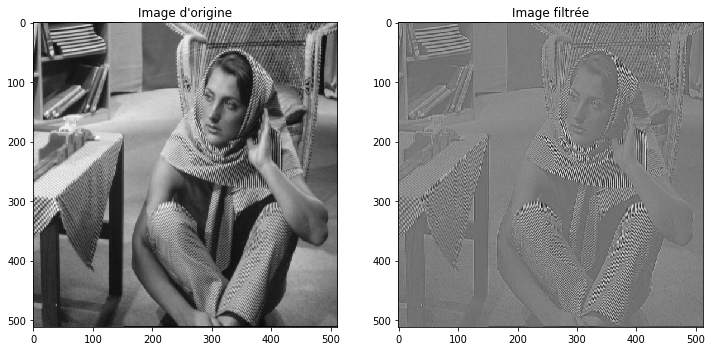

In [51]:
# Noyau de convolution
k = np.array([[-1, -1, -1],[-1, 9, -1],[-1, -1, -1],])

# Application du filtre avec la fonction convolve de Scipy
res = convolve(barbara, k, output=np.float64, mode='nearest')

affichage_1x2(barbara, res)

## <span style="color: DodgerBlue;text-decoration: underline">III.2 Filtre de Sobel</span>

Le filtre de Sobel permet de détecter des bords orientées, verticaux (Y) et/ou horizontaux (X).

<img src="https://benchpartner.com/wp-content/uploads/2019/06/sobel-filter-edge-detctor.png">

Il calcule le gradient d'intensité lumineuse pour détecter des bords orientés verticalement ou horizontalement. Un gradient élevé indique une forte variation du clair au sombre dans l'axe évalué. Il peut être appliqué sur l'axe vertical, horizontal, ou les deux.

Text(0.5, 1.0, 'Sobel Y')

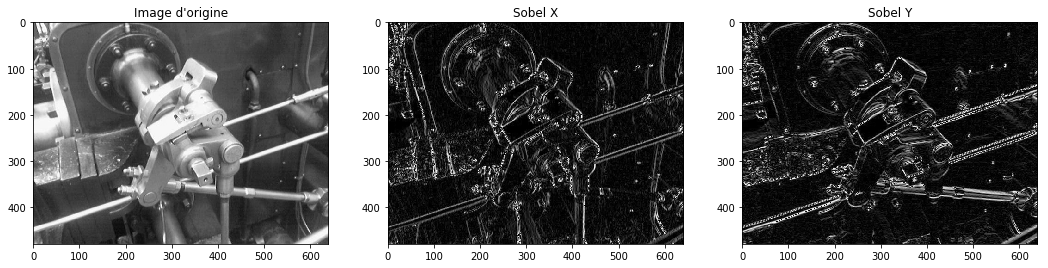

In [52]:
sobelx = cv2.Sobel(valve, cv2.CV_64F, dx=1, dy=0, ksize=3) # Sobel sur l'axe des X
sobelx = np.absolute(sobelx)
sobelx = np.uint8(sobelx)
sobely = cv2.Sobel(valve, cv2.CV_64F, dx=0, dy=1, ksize=3) # Sobel sur l'axe des Y
sobely = np.absolute(sobely)
sobely = np.uint8(sobely)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(1,3,1)
plt.imshow(valve, cmap="gray", origin="upper")
ax.set_title("Image d'origine")
ax = fig.add_subplot(1,3,2)
plt.imshow(sobelx, cmap="gray", origin="upper")
ax.set_title("Sobel X")
ax = fig.add_subplot(1,3,3)
plt.imshow(sobely, cmap="gray", origin="upper")
ax.set_title("Sobel Y")

## <span style="color: DodgerBlue;text-decoration: underline">III.3 Filtre de Prewitt</span>

Le filtre de Prewitt utilise deux noyaux, l'un pour l'axe horizontal (X) et l'autre pour l'axe vertical (Y). Chacun des noyaux est un filtre de gradient, similaires à ceux de Sobel.

<img src="https://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/prwgrad.gif">

Exemple:

<img src="https://turbosnu.files.wordpress.com/2016/01/prewitt.png?w=656">


## <span style="color: DodgerBlue;text-decoration: underline">III.4 Filtre Laplacien</span>

Le filtre Laplacien (discretisé) est l’opérateur de second ordre le plus fréquemment utilisé.

<img src="http://www.rroij.com/articles-images/IJAREEIE-2107-e004.gif">

```python
        h1 = np.array([[0.0, 1.0, 0.0],[1.0, -4.0, 1.0],[0.0, 1.0, 0.0],])
        h2 = np.array([[1.0, 1.0, 1.0],[1.0, -8.0, 1.0],[1.0, 1.0, 1.0],])
        h3 = np.array([[-1.0, 2.0, -1.0],[2.0, -4.0, 2.0],[-1.0, 2.0, -1.0],])
```

Visuellement, il peut être représenté comme une fonction continue :

<img src="http://lh6.ggpht.com/_8ce_Z70xgCg/Sh8ANnA49lI/AAAAAAAAAr4/_woA4gZMPUA/LoG_hat2_thumb%5B2%5D.gif?imgmax=800">

Cette fonction peut être discrétisée de plusieurs manières, expliquant les différentes variantes possibles du filtre Laplacien discret. Comme pour beaucoup d'autres filtres, il en existe des discrétisation de tailles plus grandes (5x5, 7x7, ...). 

*Remarque:* Ce filtre est tres sensible au bruit, du coup il est souvent précédé par un lissage Gaussien. La combinaison des deux opérations est appelé un Laplacien de Gaussien (LoG).

Text(0.5, 1.0, 'Laplacian 3x3 (blurred)')

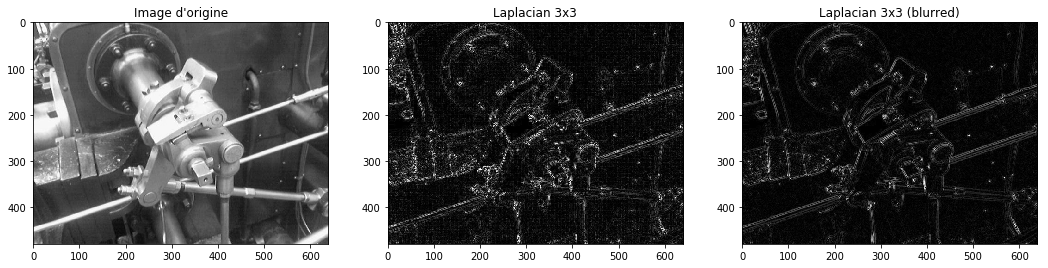

In [53]:
valve = cv2.imread("img/valve.png", 0)

laplacian3 = cv2.Laplacian(valve, cv2.CV_64F, ksize=3)
laplacian3 = np.absolute(laplacian3)
laplacian3 = np.uint8(laplacian3)

blurred = cv2.GaussianBlur(valve, (3,3), 0)

laplacian3_blurred = cv2.Laplacian(blurred, cv2.CV_64F, ksize=3)
laplacian3_blurred = np.absolute(laplacian3_blurred)
laplacian3_blurred = np.uint8(laplacian3_blurred)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(1,3,1)
plt.imshow(valve, cmap="gray", origin="upper")
ax.set_title("Image d'origine")
ax = fig.add_subplot(1,3,2)
plt.imshow(laplacian3, cmap="gray", origin="upper")
ax.set_title("Laplacian 3x3")
ax = fig.add_subplot(1,3,3)
plt.imshow(laplacian3_blurred, cmap="gray", origin="upper")
ax.set_title("Laplacian 3x3 (blurred)")

## <span style="color: DodgerBlue;text-decoration: underline">III.4 Filtre de Canny</span>

Le filtre de Canny est un filtre d'extraction de contours, également appellé *Canny Edge Detector*

La méthode d'OpenCV qui permet de réaliser un filtre de Canny est :
```python
cv2.Canny(image, threshold_lower, threshold_upper)
```

Elle se basent sur deux seuils (`threshold_lower` et `threshold_upper`) qui affectent la sensibilité de l'opétation d'extraction de contours.

Text(0.5, 1.0, 'Canny auto')

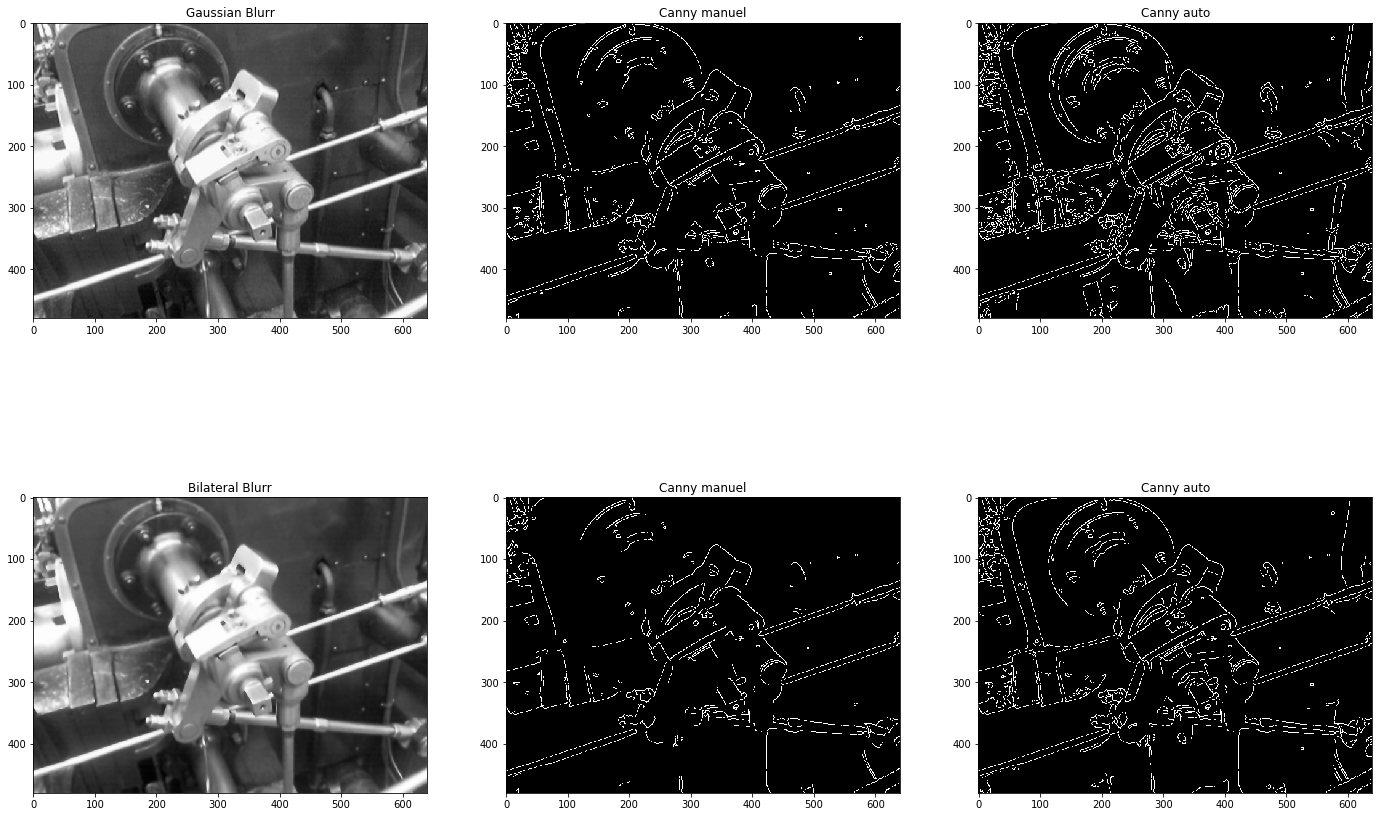

In [3]:
valve_gaussian = cv2.GaussianBlur(valve, (3,3), 0)
valve_bilateral = cv2.bilateralFilter(valve, 7, 50, 50)

# Méthode permettant de définir les seuils de la méthode cv2.Canny automatiquement
def auto_canny(image, sigma=0.33):
    
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    return edged

### Gaussian Blurr
canny_gaussian_manuel = cv2.Canny(valve_gaussian, 100, 200)
canny_gaussian_auto = auto_canny(valve_gaussian)

### Bilateral Smoothing
canny_bilateral_manuel = cv2.Canny(valve_bilateral, 100, 200)
canny_bilateral_auto = auto_canny(valve_bilateral)


### Affichage
fig = plt.figure(figsize=(24, 16))
ax = fig.add_subplot(2,3,1)
plt.imshow(valve_gaussian, cmap="gray", origin="upper")
ax.set_title("Gaussian Blurr")
ax = fig.add_subplot(2,3,2)
plt.imshow(canny_gaussian_manuel, cmap="gray", origin="upper")
ax.set_title("Canny manuel")
ax = fig.add_subplot(2,3,3)
plt.imshow(canny_gaussian_auto, cmap="gray", origin="upper")
ax.set_title("Canny auto")
ax = fig.add_subplot(2,3,4)
plt.imshow(valve_bilateral, cmap="gray", origin="upper")
ax.set_title("Bilateral Blurr")
ax = fig.add_subplot(2,3,5)
plt.imshow(canny_bilateral_manuel, cmap="gray", origin="upper")
ax.set_title("Canny manuel")
ax = fig.add_subplot(2,3,6)
plt.imshow(canny_bilateral_auto, cmap="gray", origin="upper")
ax.set_title("Canny auto")

### <span style="color:crimson">**[<u>Exercice</u>]** A vous de jouer:</span>
***
<div style="color:DarkSlateBlue">  

1. **Importez une nouvelle image (de préférence avec beaucoup de lignes horizontales et verticales, par exemple un paysage en centre-ville) et appliquez-lui les 2 filtres de Sobel, ainsi que les deux filtres de Prewitt en utilisant `filter2D` ou `convolve2D`.**

    <u>Astuce:</u> vous pouvez transposer les filtres X de Sobel / Prewitt en leur version Y avec Numpy: 

```python
Gy=np.transpose(dx)
```

2. **Affichez l'image d'origine et les 4 images résultantes et comparer les résultats.**

    
3. **Fusionnez les images obtenues par Sobel X et Y, et affichez les 4 images dans un carré (original, X, Y, X+Y).**

    
4. **Répétez les questions 1 à 3 avec les fonctions dédiées d'OpenCV.**

    
5. **Répétez l'opération en appliquant d'abord un filtre Gaussien à l'image d'origine.**

    
6. **Répétez les questions 1 à 3 avec les 3 versions du filtre Laplacien, puis avec la fonction dédiée d'OpenCV.**

    
7. **Appliquez un filtre Gaussien (pour en faire un LoG) à votre image et répétez la question 6.**
    
</div>

In [2]:
# > Emplacement exercice <



<div style="color:Navy"> 

***
# Fin du TP4
***
    
</div>